# Ranked
- Base on RFM(i.e Recency, Frequency, Monetary Value)

In [1]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()
%matplotlib inline

In [2]:
df = pd.read_csv("OnlineRetail.csv", encoding = "ISO-8859-1")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


- Preprocessing

In [3]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
# Same with OnlineRetail_Explore we will be only UK data
df = df[df['Country'] == 'United Kingdom']
df.drop(['StockCode', 'Description'], axis=1, inplace=True)
df['InvoiceYearMonth'] = df['InvoiceDate'].dt.year * 100 + df['InvoiceDate'].dt.month
df['Revenue'] = df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Revenue
0,536365,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012,15.30
1,536365,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34
2,536365,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,201012,22.00
3,536365,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34
4,536365,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34


- Function to sort for RFM cluster

In [4]:
def sort_cluster(df, group_field, sort_field,ranked_field, by_ascending=True):
    df_star = df[[group_field, sort_field]].groupby(group_field).mean()
    df_star.sort_values(by=sort_field, ascending=by_ascending, inplace=True)
    df_star.reset_index(inplace=True)
    df_star[ranked_field] = df_star.index + 1
    df_star.drop(sort_field, axis=1, inplace=True)
    return df_star

## Recency Ranking

In [5]:
max_day = df['InvoiceDate'].max()
# Find the last day active of each customer
df_recency = df[['CustomerID', 'InvoiceDate']].groupby('CustomerID').max().reset_index()
df_recency.columns = ['CustomerID', 'LastPurchaseDate']
df_recency['Recency'] = (max_day - df_recency['LastPurchaseDate']).dt.days
df_recency.drop('LastPurchaseDate', axis=1, inplace=True)
df_recency

,CustomerID,Recency
0,12346.0,325
1,12747.0,1
2,12748.0,0
3,12749.0,3
4,12820.0,2
...,...,...
3945,18280.0,277
3946,18281.0,180
3947,18282.0,7
3948,18283.0,3


In [6]:
df_recency['Recency'].describe()

count    3950.000000
mean       90.778481
std       100.230349
min         0.000000
25%        16.000000
50%        49.000000
75%       142.000000
max       373.000000
Name: Recency, dtype: float64

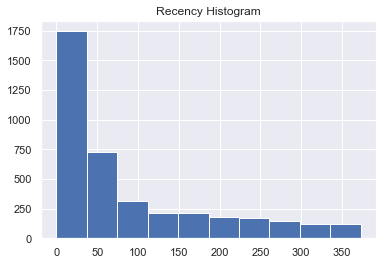

In [7]:
plt.hist(df_recency['Recency'])
plt.title('Recency Histogram')
plt.show()

### Clustering recency score

Apply Elbow Method to optimal cluster number for K-Means Algorithm

In [8]:
from sklearn.cluster import KMeans

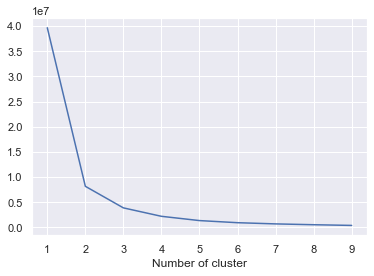

In [9]:
see = {}
df_re = df_recency[['Recency']]
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, max_iter=1000).fit(df_re)
#     df_recency['clusters'] = kmeans.labels_
    see[i] = kmeans.inertia_
plt.figure()
plt.plot(list(see.keys()), list(see.values()))
plt.xlabel("Number of cluster")
plt.show()

This graph look like have 3 elbows. 
Based on business requirements, we can go ahead with less or more clusters. 
I will be selecting 5 for this

In [10]:
kmeans = KMeans(n_clusters=5)
X = df_recency['Recency'].to_numpy().reshape((-1, 1))
kmeans.fit(X)

KMeans(n_clusters=5)

In [11]:
df_recency['ClustersRecency'] = kmeans.labels_
df_recency

,CustomerID,Recency,ClustersRecency
0,12346.0,325,2
1,12747.0,1,3
2,12748.0,0,3
3,12749.0,3,3
4,12820.0,2,3
...,...,...,...
3945,18280.0,277,4
3946,18281.0,180,0
3947,18282.0,7,3
3948,18283.0,3,3


In [12]:
df_star_rec = sort_cluster(df_recency,'ClustersRecency','Recency', 'RecencyRanked', False)
df_star_rec

,ClustersRecency,RecencyRanked
0,2,1
1,4,2
2,0,3
3,1,4
4,3,5


In [13]:
df_merge_rec = pd.merge(df_recency, df_star_rec, on='ClustersRecency')
df_merge_rec

,CustomerID,Recency,ClustersRecency,RecencyRanked
0,12346.0,325,2,1
1,12829.0,321,2,1
2,12855.0,372,2,1
3,12870.0,365,2,1
4,12872.0,326,2,1
...,...,...,...,...
3945,18248.0,113,0,3
3946,18260.0,172,0,3
3947,18262.0,139,0,3
3948,18268.0,133,0,3


In [15]:
df_merge_rec.groupby('RecencyRanked')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyRanked,,,,,,,,
1,262.0,336.003817,27.182158,291.0,311.0,331.0,364.0,373.0
2,406.0,245.337438,25.585816,201.0,220.5,246.0,266.0,290.0
3,487.0,155.971253,25.588127,113.0,133.0,156.0,177.0,200.0
4,944.0,69.141949,18.630099,43.0,53.0,65.0,81.0,112.0
5,1851.0,16.049163,11.988114,0.0,6.0,15.0,25.0,42.0


## Frequency

In [16]:
df_fre = df[['CustomerID', 'InvoiceDate']].groupby('CustomerID').count().reset_index()
df_fre.columns = ['CustomerID', 'Frequency']
df_fre

,CustomerID,Frequency
0,12346.0,2
1,12747.0,103
2,12748.0,4642
3,12749.0,231
4,12820.0,59
...,...,...
3945,18280.0,10
3946,18281.0,7
3947,18282.0,13
3948,18283.0,756


### Clustering

In [17]:
X = df_fre['Frequency'].to_numpy().reshape(-1, 1)
kmeans.fit(X)
df_fre['ClustersFrequency'] = kmeans.labels_
df_fre

,CustomerID,Frequency,ClustersFrequency
0,12346.0,2,0
1,12747.0,103,0
2,12748.0,4642,1
3,12749.0,231,4
4,12820.0,59,0
...,...,...,...
3945,18280.0,10,0
3946,18281.0,7,0
3947,18282.0,13,0
3948,18283.0,756,2


In [18]:
df_star_fre = sort_cluster(df_fre,'ClustersFrequency','Frequency', 'FrequencyRanked', True)
df_star_fre

,ClustersFrequency,FrequencyRanked
0,0,1
1,4,2
2,2,3
3,3,4
4,1,5


In [19]:
df_merge_fre = pd.merge(df_fre, df_star_fre, on='ClustersFrequency')
df_merge_fre

,CustomerID,Frequency,ClustersFrequency,FrequencyRanked
0,12346.0,2,0,1
1,12747.0,103,0,1
2,12820.0,59,0,1
3,12821.0,6,0,1
4,12822.0,47,0,1
...,...,...,...,...
3945,15311.0,2491,3,4
3946,16033.0,1152,3,4
3947,16549.0,981,3,4
3948,17511.0,1076,3,4


In [20]:
df_merge_fre.groupby('FrequencyRanked')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyRanked,,,,,,,,
1,3035.0,35.652389,28.167068,1.0,13.0,28.0,53.0,108.0
2,737.0,181.622795,61.159573,109.0,132.0,164.0,219.0,333.0
3,157.0,489.222930,133.207213,338.0,389.0,451.0,560.0,938.0
4,18.0,1403.111111,518.557375,977.0,1080.5,1162.5,1607.0,2782.0
5,3.0,5917.666667,1805.062418,4642.0,4885.0,5128.0,6555.5,7983.0


In [21]:
df_merge_fre[df_merge_fre['FrequencyRanked'] == 5]

,CustomerID,Frequency,ClustersFrequency,FrequencyRanked
3035,12748.0,4642,1,5
3036,14096.0,5128,1,5
3037,17841.0,7983,1,5


## Monetary Value

In [22]:
df_mon = df[['CustomerID', 'Revenue']].groupby('CustomerID').sum()
df_mon = df_mon.reset_index()
df_mon.columns = ['CustomerID', 'AllRevenue']
df_mon

,CustomerID,AllRevenue
0,12346.0,0.00
1,12747.0,4196.01
2,12748.0,29072.10
3,12749.0,3868.20
4,12820.0,942.34
...,...,...
3945,18280.0,180.60
3946,18281.0,80.82
3947,18282.0,176.60
3948,18283.0,2094.88


In [23]:
X = df_mon['AllRevenue'].to_numpy().reshape(-1, 1)
kmeans.fit(X)
df_mon['ClustersMonetary'] = kmeans.labels_
df_mon

,CustomerID,AllRevenue,ClustersMonetary
0,12346.0,0.00,0
1,12747.0,4196.01,4
2,12748.0,29072.10,3
3,12749.0,3868.20,4
4,12820.0,942.34,0
...,...,...,...
3945,18280.0,180.60,0
3946,18281.0,80.82,0
3947,18282.0,176.60,0
3948,18283.0,2094.88,0


In [24]:
df_star_mon = sort_cluster(df_mon, "ClustersMonetary", "AllRevenue", "MonetaryRanked")
df_star_mon

,ClustersMonetary,MonetaryRanked
0,0,1
1,4,2
2,3,3
3,2,4
4,1,5


In [25]:
df_merge_mon = pd.merge(df_mon, df_star_mon, on='ClustersMonetary')
df_merge_mon

,CustomerID,AllRevenue,ClustersMonetary,MonetaryRanked
0,12346.0,0.00,0,1
1,12820.0,942.34,0,1
2,12821.0,92.72,0,1
3,12822.0,918.98,0,1
4,12823.0,1759.50,0,1
...,...,...,...,...
3945,16684.0,65892.08,2,4
3946,17511.0,88125.38,2,4
3947,17949.0,52750.84,2,4
3948,17450.0,187482.17,1,5


In [26]:
df_merge_mon.groupby('MonetaryRanked')['AllRevenue'].describe()

,count,mean,std,min,25%,50%,75%,max
MonetaryRanked,,,,,,,,
1,3567.0,811.085263,769.428839,-4287.63,253.5750,538.460,1134.3400,3371.13
2,338.0,5869.319704,2514.542307,3376.96,3920.6550,5047.365,6840.9875,14634.64
3,31.0,24042.290645,7363.212058,15357.78,16967.6150,21535.900,28865.4900,40340.78
4,12.0,58472.544167,10572.069832,50415.49,51615.9425,55674.825,60227.7800,88125.38
5,2.0,221960.330000,48759.481478,187482.17,204721.2500,221960.330,239199.4100,256438.49


# Overall Ranked

In [70]:
full_df = pd.merge(df_merge_rec, pd.merge(df_merge_fre, df_merge_mon, on='CustomerID'), on='CustomerID')
full_df['OverallScore'] = full_df['RecencyRanked'] + full_df['FrequencyRanked'] + full_df['MonetaryRanked']
full_df

,CustomerID,Recency,ClustersRecency,RecencyRanked,Frequency,ClustersFrequency,FrequencyRanked,AllRevenue,ClustersMonetary,MonetaryRanked,OverallScore
0,12346.0,325,2,1,2,0,1,0.00,0,1,3
1,12829.0,321,2,1,12,0,1,253.05,0,1,3
2,12855.0,372,2,1,3,0,1,38.10,0,1,3
3,12870.0,365,2,1,2,0,1,-14.90,0,1,3
4,12872.0,326,2,1,66,0,1,599.97,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...
3945,18248.0,113,0,3,49,0,1,783.02,0,1,5
3946,18260.0,172,0,3,140,4,2,2595.00,0,1,6
3947,18262.0,139,0,3,13,0,1,149.48,0,1,5
3948,18268.0,133,0,3,2,0,1,0.00,0,1,5


In [71]:
full_df.groupby('OverallScore')[['RecencyRanked', 'FrequencyRanked', 'MonetaryRanked']].describe()

RecencyRanked                                               \
                     count      mean       std  min  25%  50%  75%  max   
OverallScore                                                              
3                    256.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0   
4                    399.0  1.989975  0.099747  1.0  2.0  2.0  2.0  2.0   
5                    457.0  2.971554  0.190970  1.0  3.0  3.0  3.0  3.0   
6                    833.0  3.949580  0.229659  2.0  4.0  4.0  4.0  4.0   
7                   1212.0  4.891914  0.318492  3.0  5.0  5.0  5.0  5.0   
8                    442.0  4.950226  0.217724  4.0  5.0  5.0  5.0  5.0   
9                    212.0  4.981132  0.136381  4.0  5.0  5.0  5.0  5.0   
10                   101.0  5.000000  0.000000  5.0  5.0  5.0  5.0  5.0   
11                    24.0  5.000000  0.000000  5.0  5.0  5.0  5.0  5.0   
12                     5.0  5.000000  0.000000  5.0  5.0  5.0  5.0  5.0   
13                     8.0  5.000000  0.000000  5.0  5.0  5.0  5.0  5.0   
14                     1.0  5.000000       NaN  5.0  5.0  5.0  5.0  5.0   

             FrequencyRanked            ...            MonetaryRanked  \
                       count      mean  ...   75%  max          count   
OverallScore                            ...                             
3                      256.0  1.000000  ...  1.00  1.0          256.0   
4                      399.0  1.010025  ...  1.00  2.0          399.0   
5                      457.0  1.019694  ...  1.00  2.0          457.0   
6                      833.0  1.039616  ...  1.00  2.0          833.0   
7                     1212.0  1.095710  ...  1.00  3.0         1212.0   
8                      442.0  1.929864  ...  2.00  3.0          442.0   
9                      212.0  2.226415  ...  2.00  3.0          212.0   
10                     101.0  2.861386  ...  3.00  4.0          101.0   
11                      24.0  3.333333  ...  4.00  4.0           24.0   
12                       5.0  3.400000  ...  4.00  4.0            5.0   
13                       8.0  4.000000  ...  4.25  5.0            8.0   
14                       1.0  5.000000  ...  5.00  5.0            1.0   

                                                             
                  mean       std  min   25%  50%   75%  max  
OverallScore                                                 
3             1.000000  0.000000  1.0  1.00  1.0  1.00  1.0  
4             1.000000  0.000000  1.0  1.00  1.0  1.00  1.0  
5             1.008753  0.093248  1.0  1.00  1.0  1.00  2.0  
6             1.010804  0.114474  1.0  1.00  1.0  1.00  3.0  
7             1.012376  0.110604  1.0  1.00  1.0  1.00  2.0  
8             1.119910  0.325224  1.0  1.00  1.0  1.00  2.0  
9             1.792453  0.440099  1.0  2.00  2.0  2.00  3.0  
10            2.138614  0.400742  1.0  2.00  2.0  2.00  4.0  
11            2.666667  0.701964  2.0  2.00  3.0  3.00  4.0  
12            3.600000  0.547723  3.0  3.00  4.0  4.00  4.0  
13            4.000000  0.755929  3.0  3.75  4.0  4.25  5.0  
14            4.000000       NaN  4.0  4.00  4.0  4.00  4.0  

[12 rows x 24 columns]

#### The score between 3 and 15. But we can see in describe, max OverallScore is 14
#### We can define type of customer base on Overall Score
#### I select:
- 3 to 5: Low Value
- 6 to 10: Mid Value
- more than 10: High Value

In [72]:
full_df['CustomerValue'] = 'Low Value'
full_df.loc[(full_df['OverallScore'] >= 6) & (full_df['OverallScore'] <= 10), 'CustomerValue'] = 'Mid Value'
full_df.loc[full_df['OverallScore'] > 10, 'CustomerValue'] = 'High Value'
full_df

,CustomerID,Recency,ClustersRecency,RecencyRanked,Frequency,ClustersFrequency,FrequencyRanked,AllRevenue,ClustersMonetary,MonetaryRanked,OverallScore,CustomerValue
0,12346.0,325,2,1,2,0,1,0.00,0,1,3,Low Value
1,12829.0,321,2,1,12,0,1,253.05,0,1,3,Low Value
2,12855.0,372,2,1,3,0,1,38.10,0,1,3,Low Value
3,12870.0,365,2,1,2,0,1,-14.90,0,1,3,Low Value
4,12872.0,326,2,1,66,0,1,599.97,0,1,3,Low Value
...,...,...,...,...,...,...,...,...,...,...,...,...
3945,18248.0,113,0,3,49,0,1,783.02,0,1,5,Low Value
3946,18260.0,172,0,3,140,4,2,2595.00,0,1,6,Mid Value
3947,18262.0,139,0,3,13,0,1,149.48,0,1,5,Low Value
3948,18268.0,133,0,3,2,0,1,0.00,0,1,5,Low Value


In [73]:
full_df.groupby('CustomerValue')['CustomerValue'].describe()

,count,unique,top,freq
CustomerValue,,,,
High Value,38,1,High Value,38
Low Value,1112,1,Low Value,1112
Mid Value,2800,1,Mid Value,2800


In [74]:
full_df.columns

Index(['CustomerID', 'Recency', 'ClustersRecency', 'RecencyRanked',
       'Frequency', 'ClustersFrequency', 'FrequencyRanked', 'AllRevenue',
       'ClustersMonetary', 'MonetaryRanked', 'OverallScore', 'CustomerValue'],
      dtype='object')

## Visualization Data

### Revenue vs Frequency

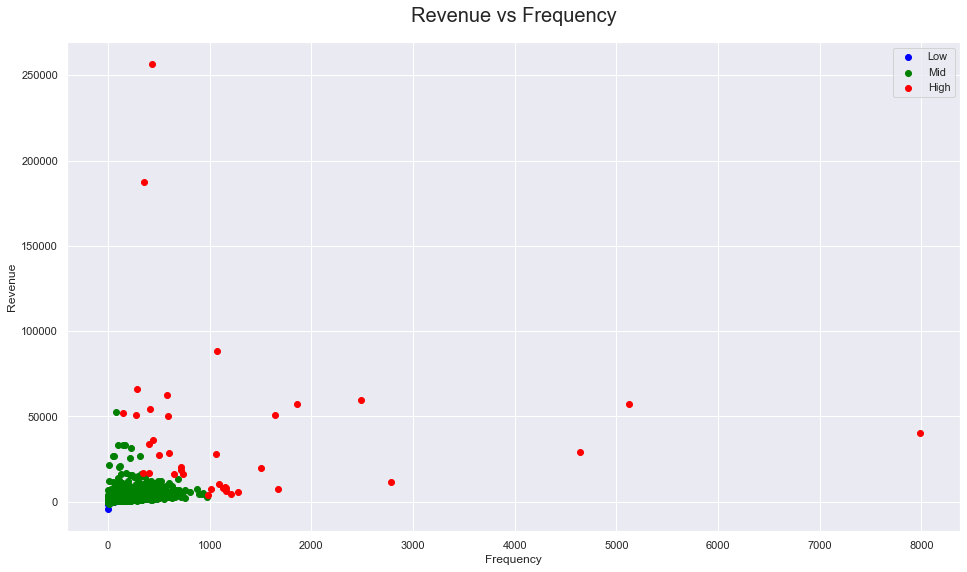

In [81]:
plt.figure(figsize=(16, 9))

# full_df = full_df.query("AllRevenue < 4000 and Frequency < 100000")

fre_low = full_df.query("CustomerValue == 'Low Value'")["Frequency"]
rev_low = full_df.query("CustomerValue == 'Low Value'")["AllRevenue"]
plt.scatter(fre_low, rev_low, color='blue', label='Low')

fre_mid = full_df.query("CustomerValue == 'Mid Value'")["Frequency"]
rev_mid = full_df.query("CustomerValue == 'Mid Value'")["AllRevenue"]
plt.scatter(fre_mid, rev_mid, color='green', label='Mid')

fre_high = full_df.query("CustomerValue == 'High Value'")["Frequency"]
rev_high = full_df.query("CustomerValue == 'High Value'")["AllRevenue"]
plt.scatter(fre_high, rev_high, color='red', label='High')

plt.xlabel("Frequency")
plt.ylabel("Revenue")
plt.title("Revenue vs Frequency", pad=20, fontsize=20)
plt.legend()
plt.show()


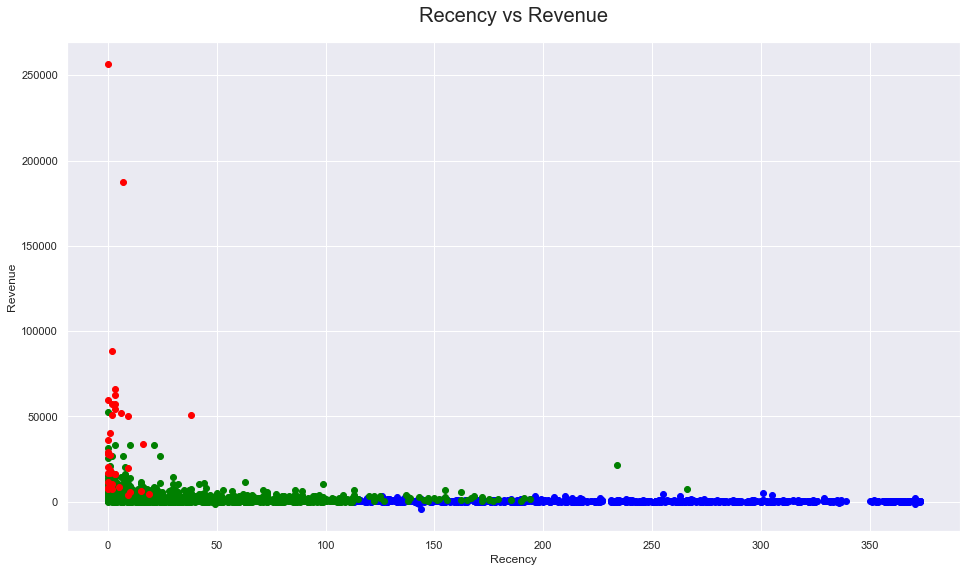

In [80]:
plt.figure(figsize=(16, 9))
# full_df = full_df.query("Recency < 2000 and AllRevenue < 100000")

rec_low = full_df.query("CustomerValue == 'Low Value'")['Recency']
plt.scatter(rec_low, rev_low, label='Low', color='blue')

rec_mid = full_df.query("CustomerValue == 'Mid Value'")['Recency']
plt.scatter(rec_mid, rev_mid, label='Mid', color='green')

rec_high = full_df.query("CustomerValue == 'High Value'")['Recency']
plt.scatter(rec_high, rev_high, label='High', color='red')

plt.xlabel('Recency')
plt.ylabel('Revenue')
plt.title('Recency vs Revenue', pad=20, fontsize=20)
plt.show()

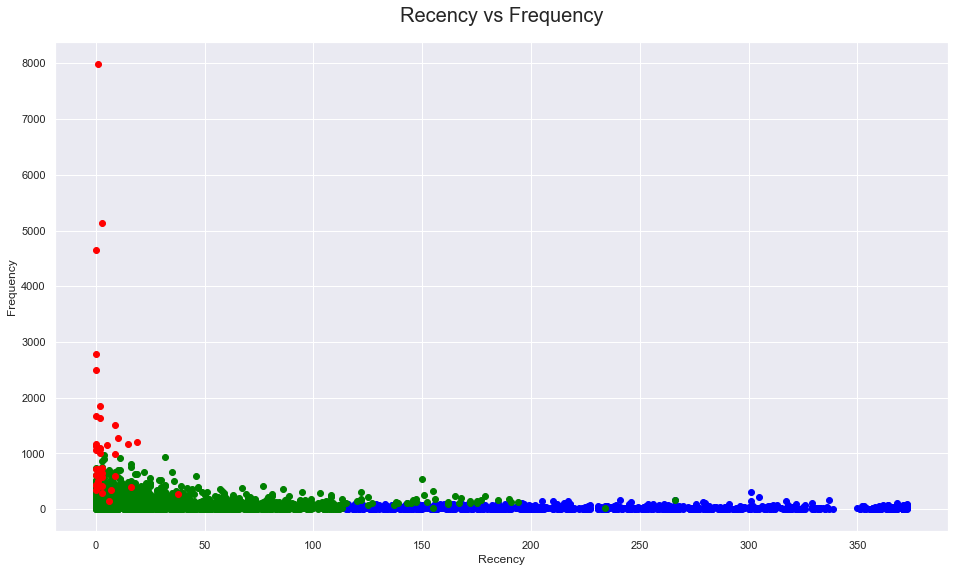

In [85]:
plt.figure(figsize=(16, 9))
# full_df = full_df.query("Recency < 2000 and Frequency < 5000")

plt.scatter(rec_low, fre_low, label='Low', color='blue')

plt.scatter(rec_mid, fre_mid, label='Mid', color='green')

plt.scatter(rec_high, fre_high, label='High', color='red')

plt.xlabel('Recency')
plt.ylabel('Frequency')
plt.title('Recency vs Frequency', pad=20, fontsize=20)
plt.show()

### Conclusion
#### We completed segment customer. So we treat every customer base on their value and undertand them better.
#### On the others hands, we need improve each customer value:
- High Value: Improve Retention
- Mid Value: Improve Retention + Frequency
- Low Value: Increase Frequency